 ### Sales, Demand & Business Forecasting 
### Walmart Sales Forecasting       -  Mohit 
Problem: Predict weekly sales for stores & departments 
ML Type: Regression, Time-series features, XGBoost 
🔗 Dataset: 
https://www.kaggle.com/datasets/yasserh/walmart-dataset 
### Why good ML project 
1M+ rows 

Feature engineering (holidays, markdowns) 

Tree models outperform deep learning here

In [1]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# --------------------------------------------------------
# 1) Load Data
# --------------------------------------------------------
df = pd.read_csv("Walmart.csv")

# Convert date to datetime
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)



In [3]:

# --------------------------------------------------------
# 2) Simple Feature Engineering
# --------------------------------------------------------
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Week"] = df["Date"].dt.isocalendar().week.astype(int)

# Features to use
feature_cols = [
    "Store", "Holiday_Flag", "Temperature",
    "Fuel_Price", "CPI", "Unemployment",
    "Year", "Month", "Week"
]

X = df[feature_cols]
y = df["Weekly_Sales"]

# --------------------------------------------------------
# 3) Train-Test Split
# --------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# --------------------------------------------------------
# 4) Train XGBoost Model
# --------------------------------------------------------
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

# --------------------------------------------------------
# 5) Make Predictions
# --------------------------------------------------------
pred = model.predict(X_test)
rmse = mean_squared_error(y_test, pred, squared=False)
print("RMSE:", rmse)

# --------------------------------------------------------
# 6) Save predictions
# --------------------------------------------------------
output = X_test.copy()
output["Actual_Sales"] = y_test.values
output["Predicted_Sales"] = pred
output.to_csv("simple_walmart_predictions.csv", index=False)

print("Saved file: simple_walmart_predictions.csv")


TypeError: got an unexpected keyword argument 'squared'

In [4]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# 1) Load Data
df = pd.read_csv("Walmart.csv")
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)

# 2) Simple Feature Engineering
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Week"] = df["Date"].dt.isocalendar().week.astype(int)

feature_cols = [
    "Store", "Holiday_Flag", "Temperature",
    "Fuel_Price", "CPI", "Unemployment",
    "Year", "Month", "Week"
]

X = df[feature_cols]
y = df["Weekly_Sales"]

# 3) Train-Test Split (time order 유지 → no shuffle)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# 4) Train XGBoost Model
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

# 5) Predict + RMSE (fixed for older sklearn)
pred = model.predict(X_test)

mse = mean_squared_error(y_test, pred)   # no squared parameter
rmse = mse ** 0.5
print("RMSE:", rmse)

# 6) Save predictions
output = X_test.copy()
output["Actual_Sales"] = y_test.values
output["Predicted_Sales"] = pred

output.to_csv("simple_walmart_predictions.csv", index=False)
print("Saved file: simple_walmart_predictions.csv")


RMSE: 518952.6892860191
Saved file: simple_walmart_predictions.csv


RMSE: 518952.6892860191


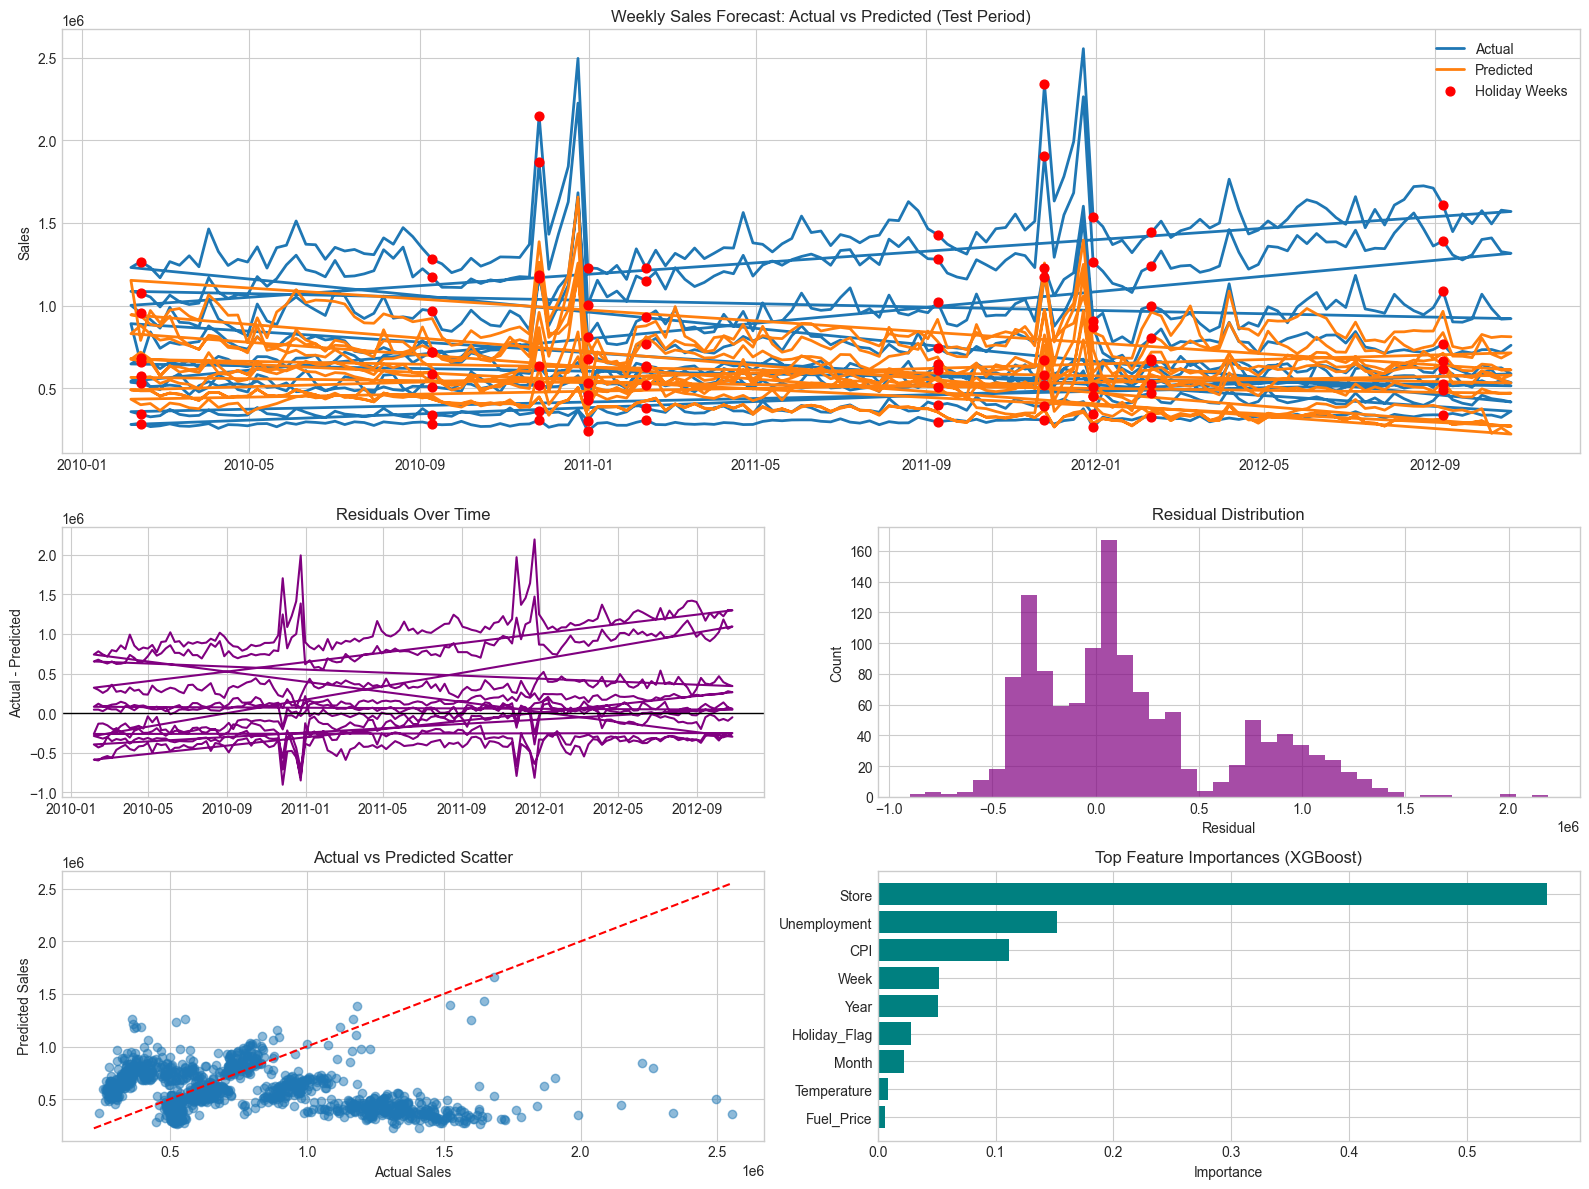

In [6]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# -----------------------------
# Load + feature engineering
# -----------------------------
df = pd.read_csv("Walmart.csv")
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)

df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Week"] = df["Date"].dt.isocalendar().week.astype(int)

feature_cols = [
    "Store", "Holiday_Flag", "Temperature",
    "Fuel_Price", "CPI", "Unemployment",
    "Year", "Month", "Week"
]

X = df[feature_cols]
y = df["Weekly_Sales"]

# Time-based split (no shuffle)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# -----------------------------
# Train model
# -----------------------------
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# -----------------------------
# Predict + metrics
# -----------------------------
pred = model.predict(X_test)
rmse = mean_squared_error(y_test, pred) ** 0.5
print("RMSE:", rmse)

# Build a results df (keep Date for plotting)
res = df.iloc[len(df) - len(X_test):].copy()
res["Predicted_Sales"] = pred
res["Residual"] = res["Weekly_Sales"] - res["Predicted_Sales"]

# -----------------------------
# Create connected subplot dashboard
# -----------------------------
plt.style.use("seaborn-v0_8-whitegrid")
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, height_ratios=[2.2, 1.4, 1.4])

# 1) Actual vs Predicted (Connected x-axis = Date)
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(res["Date"], res["Weekly_Sales"], label="Actual", linewidth=2)
ax1.plot(res["Date"], res["Predicted_Sales"], label="Predicted", linewidth=2)

# Mark holidays
holiday_points = res[res["Holiday_Flag"] == 1]
ax1.scatter(holiday_points["Date"], holiday_points["Weekly_Sales"], 
            color="red", s=40, label="Holiday Weeks", zorder=5)

ax1.set_title("Weekly Sales Forecast: Actual vs Predicted (Test Period)")
ax1.set_ylabel("Sales")
ax1.legend()

# 2) Residuals over time
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax2.plot(res["Date"], res["Residual"], color="purple")
ax2.axhline(0, color="black", linewidth=1)
ax2.set_title("Residuals Over Time")
ax2.set_ylabel("Actual - Predicted")

# 3) Residual distribution (hist)
ax3 = fig.add_subplot(gs[1, 1])
ax3.hist(res["Residual"], bins=40, color="purple", alpha=0.7)
ax3.set_title("Residual Distribution")
ax3.set_xlabel("Residual")
ax3.set_ylabel("Count")

# 4) Actual vs Predicted scatter
ax4 = fig.add_subplot(gs[2, 0])
ax4.scatter(res["Weekly_Sales"], res["Predicted_Sales"], alpha=0.5)
minv = min(res["Weekly_Sales"].min(), res["Predicted_Sales"].min())
maxv = max(res["Weekly_Sales"].max(), res["Predicted_Sales"].max())
ax4.plot([minv, maxv], [minv, maxv], "r--")
ax4.set_title("Actual vs Predicted Scatter")
ax4.set_xlabel("Actual Sales")
ax4.set_ylabel("Predicted Sales")

# 5) Feature importance (top 12)
ax5 = fig.add_subplot(gs[2, 1])
importances = model.feature_importances_
imp = pd.Series(importances, index=feature_cols).sort_values(ascending=False).head(12)
ax5.barh(imp.index[::-1], imp.values[::-1], color="teal")
ax5.set_title("Top Feature Importances (XGBoost)")
ax5.set_xlabel("Importance")

plt.tight_layout()
plt.show()


In [13]:

# ============================================================
# Walmart Forecasting + Plotly (No nbformat error)
# ============================================================

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

# ✅ FIX: Use browser rendering to avoid nbformat dependency
pio.renderers.default = "browser"

# Optional safe show helper (won't crash even if renderer fails)
def safe_show(fig):
    try:
        fig.show()
    except Exception as e:
        print("Plotly show() failed, saving HTML instead:", e)
        fig.write_html("plotly_fallback.html")
        print("Saved: plotly_fallback.html (open in browser)")

# -----------------------------
# Load + feature engineering
# -----------------------------
df = pd.read_csv("Walmart.csv")
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
df = df.dropna(subset=["Date", "Weekly_Sales"]).copy()
df = df.sort_values(["Date", "Store"]).reset_index(drop=True)

df["Year"]  = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Week"]  = df["Date"].dt.isocalendar().week.astype(int)

feature_cols = [
    "Store", "Holiday_Flag", "Temperature",
    "Fuel_Price", "CPI", "Unemployment",
    "Year", "Month", "Week"
]

X = df[feature_cols].copy()
y = df["Weekly_Sales"].copy()

# Time-based split (no shuffle)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
test_index = X_test.index

# -----------------------------
# Scaling (optional)
# -----------------------------
scaler = StandardScaler()
scale_cols = ["Temperature", "Fuel_Price", "CPI", "Unemployment", "Year", "Month", "Week"]

X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()

X_train_scaled[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test_scaled[scale_cols]  = scaler.transform(X_test[scale_cols])

# -----------------------------
# Train model
# -----------------------------
model = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective="reg:squarederror",
    tree_method="hist"
)
model.fit(X_train_scaled, y_train)

# -----------------------------
# Predict + metrics
# -----------------------------
pred = model.predict(X_test_scaled)
rmse = mean_squared_error(y_test, pred) ** 0.5
mae  = mean_absolute_error(y_test, pred)

print(f"RMSE: {rmse:,.2f}")
print(f"MAE : {mae:,.2f}")

# -----------------------------
# Prediction records (aligned)
# -----------------------------
pred_records = df.loc[test_index, ["Date", "Store", "Holiday_Flag", "Weekly_Sales"]].copy()
pred_records["Predicted_Sales"] = pred
pred_records["Residual"] = pred_records["Weekly_Sales"] - pred_records["Predicted_Sales"]
pred_records["Abs_Error"] = pred_records["Residual"].abs()

pred_records = pred_records.sort_values(["Store", "Date"]).reset_index(drop=True)
pred_records.to_csv("prediction_records.csv", index=False)
print("Saved: prediction_records.csv")

# Overall totals (clean line chart)
overall = pred_records.groupby("Date", as_index=False).agg(
    Actual_Total=("Weekly_Sales", "sum"),
    Pred_Total=("Predicted_Sales", "sum"),
    Holiday_Flag=("Holiday_Flag", "max")
)
overall["Residual"] = overall["Actual_Total"] - overall["Pred_Total"]

# ============================================================
# Plotly charts (separate)
# ============================================================

# 1) Overall Actual vs Predicted (Line)
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=overall["Date"], y=overall["Actual_Total"], mode="lines",
                          name="Actual (Total)", line=dict(width=3)))
fig1.add_trace(go.Scatter(x=overall["Date"], y=overall["Pred_Total"], mode="lines",
                          name="Predicted (Total)", line=dict(width=3, dash="dash")))

hol = overall[overall["Holiday_Flag"] == 1]
fig1.add_trace(go.Scatter(x=hol["Date"], y=hol["Actual_Total"], mode="markers",
                          name="Holiday", marker=dict(color="red", size=8)))

fig1.update_layout(
    title=f"Overall Weekly Sales — Actual vs Predicted | RMSE={rmse:,.2f}",
    template="plotly_white",
    xaxis_title="Date",
    yaxis_title="Total Weekly Sales",
    hovermode="x unified"
)
safe_show(fig1)

# 2) Store Dropdown Line Chart (Actual vs Pred)
stores = sorted(pred_records["Store"].unique())
default_store = stores[0]

fig2 = go.Figure()

for s in stores:
    temp = pred_records[pred_records["Store"] == s].sort_values("Date")
    visible = (s == default_store)
    fig2.add_trace(go.Scatter(x=temp["Date"], y=temp["Weekly_Sales"],
                              mode="lines", name=f"Actual (Store {s})", visible=visible))
    fig2.add_trace(go.Scatter(x=temp["Date"], y=temp["Predicted_Sales"],
                              mode="lines", name=f"Predicted (Store {s})",
                              line=dict(dash="dash"), visible=visible))

buttons = []
for i, s in enumerate(stores):
    vis = [False] * (2 * len(stores))
    vis[2*i] = True
    vis[2*i + 1] = True
    buttons.append(dict(
        label=f"Store {s}",
        method="update",
        args=[{"visible": vis},
              {"title": f"Store {s} — Actual vs Predicted (Test)"}]
    ))

fig2.update_layout(
    title=f"Store {default_store} — Actual vs Predicted (Test)",
    template="plotly_white",
    xaxis_title="Date",
    yaxis_title="Weekly Sales",
    hovermode="x unified",
    updatemenus=[dict(buttons=buttons, direction="down", x=1.02, y=1.0, xanchor="left", yanchor="top")]
)
safe_show(fig2)

# 3) Residuals Over Time (Overall)
fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=overall["Date"], y=overall["Residual"], mode="lines",
                          name="Residual", line=dict(color="purple")))
fig3.add_hline(y=0, line_width=1, line_color="black")
fig3.update_layout(
    title="Residuals Over Time (Overall)",
    template="plotly_white",
    xaxis_title="Date",
    yaxis_title="Actual - Predicted",
    hovermode="x unified"
)
safe_show(fig3)

# 4) Residual Histogram
fig4 = px.histogram(overall, x="Residual", nbins=40, title="Residual Distribution (Overall)", template="plotly_white")
safe_show(fig4)

# 5) Actual vs Pred Scatter (rows)
fig5 = px.scatter(pred_records, x="Weekly_Sales", y="Predicted_Sales", color="Holiday_Flag",
                  title="Actual vs Predicted (Test Rows)", template="plotly_white")
safe_show(fig5)

# 6) Feature importance
imp = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False).head(12)
fig6 = px.bar(x=imp.values[::-1], y=imp.index[::-1], orientation="h",
             title="Top Feature Importances (XGBoost)", template="plotly_white")
safe_show(fig6)

print("All plots shown (browser) ✅")


RMSE: 126,118.44
MAE : 91,919.48
Saved: prediction_records.csv
All plots shown (browser) ✅


In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

import plotly.graph_objects as go
import plotly.express as px

from dash import Dash, dcc, html, Input, Output

# -----------------------------------
# LOAD + FEATURES
# -----------------------------------
df = pd.read_csv("Walmart.csv")
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)

df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Week"] = df["Date"].dt.isocalendar().week.astype(int)

features = ["Store","Holiday_Flag","Temperature","Fuel_Price","CPI",
            "Unemployment","Year","Month","Week"]

X = df[features]
y = df["Weekly_Sales"]

# Time-based split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, shuffle=False
)

test_idx = X_test.index

# -----------------------------------
# MODEL
# -----------------------------------
model = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8
)
model.fit(X_train, y_train)

pred = model.predict(X_test)
rmse = mean_squared_error(y_test, pred)**0.5

# -----------------------------------
# PREDICTION RESULTS
# -----------------------------------
res = df.loc[test_idx, ["Date","Store","Weekly_Sales","Holiday_Flag"]].copy()
res["Predicted"] = pred
res["Residual"] = res["Weekly_Sales"] - res["Predicted"]

# overall totals by date
overall = res.groupby("Date", as_index=False).agg(
    Actual=("Weekly_Sales","sum"),
    Pred=("Predicted","sum"),
    Holiday=("Holiday_Flag","max")
)

stores = sorted(res["Store"].unique())

# -----------------------------------
# SIMPLE FIGURE FUNCTIONS
# -----------------------------------
def overall_line():
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=overall["Date"], y=overall["Actual"],
                             mode="lines", name="Actual"))
    fig.add_trace(go.Scatter(x=overall["Date"], y=overall["Pred"],
                             mode="lines", name="Predicted",
                             line=dict(dash="dash")))
    fig.update_layout(title=f"Overall Weekly Sales (RMSE: {rmse:,.2f})",
                      template="plotly_white")
    return fig

def store_line(store):
    sd = res[res["Store"]==store]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=sd["Date"], y=sd["Weekly_Sales"],
                             mode="lines", name="Actual"))
    fig.add_trace(go.Scatter(x=sd["Date"], y=sd["Predicted"],
                             mode="lines", name="Predicted",
                             line=dict(dash="dash")))
    fig.update_layout(title=f"Store {store} — Actual vs Predicted",
                      template="plotly_white")
    return fig

def store_residual(store):
    sd = res[res["Store"]==store]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=sd["Date"], y=sd["Residual"],
                             mode="lines", name="Residual"))
    fig.update_layout(title=f"Store {store} — Residuals",
                      template="plotly_white")
    return fig

# -----------------------------------
# DASH APP (CLEAN & EASY)
# -----------------------------------
app = Dash(__name__)

app.layout = html.Div([
    html.H2("Walmart Forecast Dashboard"),

    dcc.Graph(figure=overall_line()),

    html.H4("Select Store"),
    dcc.Dropdown(id="store_dd",
                 options=[{"label":f"Store {s}","value":s} for s in stores],
                 value=stores[0],
                 style={"width":"300px"}),

    dcc.Graph(id="store_line"),
    dcc.Graph(id="store_res")
])

@app.callback(
    Output("store_line","figure"),
    Output("store_res","figure"),
    Input("store_dd","value")
)
def update(store):
    return store_line(store), store_residual(store)

# -----------------------------------
# RUN ON 127.0.0.1
# -----------------------------------
if __name__ == "__main__":
    app.run(host="127.0.0.1", port=8050, debug=True)


In [24]:

import webbrowser
from threading import Timer

# ============================================================
# Walmart Forecasting Dashboard (ALL-IN-ONE on 127.0.0.1)
# Run: python walmart_dashboard.py
# Open: http://127.0.0.1:8050
# ============================================================

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

import plotly.graph_objects as go
import plotly.express as px

from dash import Dash, dcc, html, Input, Output

# =========================
# 1) LOAD + FEATURES
# =========================
df = pd.read_csv("Walmart.csv")
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
df = df.dropna(subset=["Date", "Weekly_Sales"]).copy()
df = df.sort_values(["Date", "Store"]).reset_index(drop=True)

# Simple time features
df["Year"]  = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Week"]  = df["Date"].dt.isocalendar().week.astype(int)

feature_cols = [
    "Store", "Holiday_Flag", "Temperature",
    "Fuel_Price", "CPI", "Unemployment",
    "Year", "Month", "Week"
]

X = df[feature_cols].copy()
y = df["Weekly_Sales"].copy()

# Time split (no shuffle)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, shuffle=False
)
test_index = X_test.index

# =========================
# 2) SCALING (optional)
# =========================
scaler = StandardScaler()
scale_cols = ["Temperature", "Fuel_Price", "CPI", "Unemployment", "Year", "Month", "Week"]

X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()

X_train_scaled[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test_scaled[scale_cols]  = scaler.transform(X_test[scale_cols])

# =========================
# 3) MODEL TRAINING
# =========================
model = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective="reg:squarederror",
    tree_method="hist"
)
model.fit(X_train_scaled, y_train)

pred = model.predict(X_test_scaled)

rmse = mean_squared_error(y_test, pred) ** 0.5
mae  = mean_absolute_error(y_test, pred)

# =========================
# 4) PREDICTION RECORDS
# =========================
pred_records = df.loc[test_index, ["Date", "Store", "Holiday_Flag", "Weekly_Sales"]].copy()
pred_records["Predicted_Sales"] = pred
pred_records["Residual"] = pred_records["Weekly_Sales"] - pred_records["Predicted_Sales"]
pred_records["Abs_Error"] = pred_records["Residual"].abs()
pred_records = pred_records.sort_values(["Store", "Date"]).reset_index(drop=True)

# Save once (optional)
pred_records.to_csv("prediction_records.csv", index=False)

# Overall totals for clean business line charts
overall = pred_records.groupby("Date", as_index=False).agg(
    Actual_Total=("Weekly_Sales", "sum"),
    Pred_Total=("Predicted_Sales", "sum"),
    Holiday_Flag=("Holiday_Flag", "max")
)
overall["Residual"] = overall["Actual_Total"] - overall["Pred_Total"]
overall["Abs_Error"] = overall["Residual"].abs()

# Feature importance
imp = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False).head(12)

# =========================
# 5) STATIC FIGURES (no callbacks)
# =========================
def fig_overall_line():
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=overall["Date"], y=overall["Actual_Total"],
                             mode="lines", name="Actual (Total)", line=dict(width=3)))
    fig.add_trace(go.Scatter(x=overall["Date"], y=overall["Pred_Total"],
                             mode="lines", name="Predicted (Total)", line=dict(width=3, dash="dash")))
    hol = overall[overall["Holiday_Flag"] == 1]
    fig.add_trace(go.Scatter(x=hol["Date"], y=hol["Actual_Total"],
                             mode="markers", name="Holiday", marker=dict(color="red", size=8)))
    fig.update_layout(template="plotly_white", hovermode="x unified",
                      title="Overall Weekly Sales (All Stores): Actual vs Predicted",
                      xaxis_title="Date", yaxis_title="Total Weekly Sales")
    return fig

def fig_overall_residual_line():
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=overall["Date"], y=overall["Residual"],
                             mode="lines", name="Residual", line=dict(color="purple", width=2)))
    fig.add_hline(y=0, line_width=1, line_color="black")
    fig.update_layout(template="plotly_white", hovermode="x unified",
                      title="Overall Residuals Over Time",
                      xaxis_title="Date", yaxis_title="Actual - Predicted")
    return fig

def fig_residual_hist():
    fig = px.histogram(overall, x="Residual", nbins=40,
                       title="Residual Distribution (Overall)", template="plotly_white")
    fig.update_layout(xaxis_title="Residual", yaxis_title="Count")
    return fig

def fig_scatter_actual_pred():
    fig = px.scatter(pred_records, x="Weekly_Sales", y="Predicted_Sales", color="Holiday_Flag",
                     title="Actual vs Predicted (Test Rows) — colored by Holiday",
                     labels={"Weekly_Sales":"Actual", "Predicted_Sales":"Predicted"},
                     template="plotly_white")
    minv = float(min(pred_records["Weekly_Sales"].min(), pred_records["Predicted_Sales"].min()))
    maxv = float(max(pred_records["Weekly_Sales"].max(), pred_records["Predicted_Sales"].max()))
    fig.add_trace(go.Scatter(x=[minv, maxv], y=[minv, maxv],
                             mode="lines", name="Ideal (y=x)", line=dict(color="red", dash="dash")))
    return fig

def fig_holiday_error_box():
    fig = px.box(pred_records, x="Holiday_Flag", y="Abs_Error",
                 title="Absolute Error: Holiday vs Non-Holiday",
                 labels={"Holiday_Flag":"Holiday (0=No, 1=Yes)", "Abs_Error":"Absolute Error"},
                 template="plotly_white")
    return fig

def fig_feature_importance():
    fig = px.bar(x=imp.values[::-1], y=imp.index[::-1], orientation="h",
                 title="Top Feature Importances (XGBoost)",
                 labels={"x":"Importance", "y":"Feature"},
                 template="plotly_white")
    return fig


# =========================
# 6) DASH APP (all charts in one page)
# =========================
app = Dash(__name__)
stores = sorted(pred_records["Store"].unique())
default_store = stores[0]

app.layout = html.Div([
    html.H2("Walmart Sales Forecasting Dashboard (All-in-One)"),

    html.Div([
        html.Div([
            html.H4("Model Metrics (Test)"),
            html.Div(f"RMSE: {rmse:,.2f}"),
            html.Div(f"MAE: {mae:,.2f}"),
            html.Div("Prediction records saved as: prediction_records.csv")
        ], style={"padding": "12px", "border": "1px solid #ddd", "borderRadius": "8px", "width": "30%"}),

        html.Div([
            html.H4("Select Store (for Store-wise charts)"),
            dcc.Dropdown(
                id="store_dropdown",
                options=[{"label": f"Store {s}", "value": s} for s in stores],
                value=default_store,
                clearable=False
            )
        ], style={"padding": "12px", "border": "1px solid #ddd", "borderRadius": "8px", "width": "68%"})
    ], style={"display": "flex", "gap": "12px"}),

    html.Br(),

    # Overall charts
    dcc.Graph(figure=fig_overall_line()),
    html.Div([
        html.Div([dcc.Graph(figure=fig_overall_residual_line())], style={"width": "50%"}),
        html.Div([dcc.Graph(figure=fig_residual_hist())], style={"width": "50%"})
    ], style={"display": "flex", "gap": "10px"}),

    html.Br(),

    # Store-wise charts (updated by dropdown)
    html.H3("Store-wise Forecast"),
    dcc.Graph(id="store_line_chart"),
    dcc.Graph(id="store_residual_chart"),

    html.Br(),

    # Other charts
    html.Div([
        html.Div([dcc.Graph(figure=fig_scatter_actual_pred())], style={"width": "50%"}),
        html.Div([dcc.Graph(figure=fig_holiday_error_box())], style={"width": "50%"})
    ], style={"display": "flex", "gap": "10px"}),

    dcc.Graph(figure=fig_feature_importance()),

], style={"maxWidth": "1200px", "margin": "0 auto", "fontFamily": "Arial"})


# =========================
# 7) CALLBACKS (store charts)
# =========================
@app.callback(
    Output("store_line_chart", "figure"),
    Output("store_residual_chart", "figure"),
    Input("store_dropdown", "value")
)
def update_store_charts(store_id):
    sdf = pred_records[pred_records["Store"] == store_id].sort_values("Date")

    # Store Actual vs Pred
    fig_line = go.Figure()
    fig_line.add_trace(go.Scatter(x=sdf["Date"], y=sdf["Weekly_Sales"],
                                  mode="lines", name="Actual", line=dict(width=3)))
    fig_line.add_trace(go.Scatter(x=sdf["Date"], y=sdf["Predicted_Sales"],
                                  mode="lines", name="Predicted", line=dict(width=3, dash="dash")))
    fig_line.update_layout(template="plotly_white", hovermode="x unified",
                           title=f"Store {store_id}: Actual vs Predicted",
                           xaxis_title="Date", yaxis_title="Weekly Sales")

    # Store Residuals
    fig_res = go.Figure()
    fig_res.add_trace(go.Scatter(x=sdf["Date"], y=sdf["Residual"],
                                 mode="lines", name="Residual", line=dict(color="purple")))
    fig_res.add_hline(y=0, line_width=1, line_color="black")
    fig_res.update_layout(template="plotly_white", hovermode="x unified",
                          title=f"Store {store_id}: Residuals Over Time",
                          xaxis_title="Date", yaxis_title="Actual - Predicted")

    return fig_line, fig_res


# =========================
# 8) RUN SERVER on 127.0.0.1
# =========================
if __name__ == "__main__":
    # Port 8050 by default. Change if you want: port=12700 etc.
    app.run(host="127.0.0.1", port=8050, debug=True)


In [27]:

# ============================================================
# Walmart Mini Dashboard (Store dropdown -> charts update)
# Run: python walmart_mini_dashboard.py
# Open: http://127.0.0.1:8050
# ============================================================

import pandas as pd
import numpy as np
from threading import Timer
import webbrowser

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

import plotly.graph_objects as go
import plotly.express as px

from dash import Dash, dcc, html, Input, Output

# -----------------------------
# 1) Load & Feature Engineering
# -----------------------------
df = pd.read_csv("Walmart.csv")
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
df = df.dropna(subset=["Date", "Weekly_Sales"]).copy()
df = df.sort_values(["Date", "Store"]).reset_index(drop=True)

# Simple time features
df["Year"]  = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Week"]  = df["Date"].dt.isocalendar().week.astype(int)

feature_cols = [
    "Store", "Holiday_Flag", "Temperature",
    "Fuel_Price", "CPI", "Unemployment",
    "Year", "Month", "Week"
]

X = df[feature_cols].copy()
y = df["Weekly_Sales"].copy()

# -----------------------------
# 2) Train/Test Split (Time-based)
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, shuffle=False
)
test_idx = X_test.index

# -----------------------------
# 3) Train Model
# -----------------------------
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective="reg:squarederror",
    tree_method="hist"
)
model.fit(X_train, y_train)

pred = model.predict(X_test)

rmse = mean_squared_error(y_test, pred) ** 0.5
mae  = mean_absolute_error(y_test, pred)

# -----------------------------
# 4) Prediction Records (ALIGNED)
# -----------------------------
res = df.loc[test_idx, ["Date", "Store", "Holiday_Flag", "Weekly_Sales"]].copy()
res["Predicted"] = pred
res["Residual"]  = res["Weekly_Sales"] - res["Predicted"]
res["Abs_Error"] = res["Residual"].abs()
res = res.sort_values(["Store", "Date"]).reset_index(drop=True)

# Overall totals (for global chart)
overall = res.groupby("Date", as_index=False).agg(
    Actual=("Weekly_Sales", "sum"),
    Pred=("Predicted", "sum"),
    Holiday=("Holiday_Flag", "max")
)
overall["Residual"] = overall["Actual"] - overall["Pred"]

stores = sorted(res["Store"].unique())

# -----------------------------
# 5) Helper: figures
# -----------------------------
def fig_overall():
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=overall["Date"], y=overall["Actual"], mode="lines", name="Actual"))
    fig.add_trace(go.Scatter(x=overall["Date"], y=overall["Pred"], mode="lines",
                             name="Predicted", line=dict(dash="dash")))
    fig.update_layout(template="plotly_white", hovermode="x unified",
                      title=f"Overall Sales (All Stores) | Test RMSE={rmse:,.0f}, MAE={mae:,.0f}",
                      xaxis_title="Date", yaxis_title="Weekly Sales (Total)")
    return fig

def fig_store_line(store_id):
    sd = res[res["Store"] == store_id].sort_values("Date")
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=sd["Date"], y=sd["Weekly_Sales"], mode="lines", name="Actual"))
    fig.add_trace(go.Scatter(x=sd["Date"], y=sd["Predicted"], mode="lines",
                             name="Predicted", line=dict(dash="dash")))
    # holiday markers
    hol = sd[sd["Holiday_Flag"] == 1]
    fig.add_trace(go.Scatter(x=hol["Date"], y=hol["Weekly_Sales"], mode="markers",
                             name="Holiday", marker=dict(color="red", size=7)))
    fig.update_layout(template="plotly_white", hovermode="x unified",
                      title=f"Store {store_id}: Actual vs Predicted (Test)",
                      xaxis_title="Date", yaxis_title="Weekly Sales")
    return fig

def fig_store_residual(store_id):
    sd = res[res["Store"] == store_id].sort_values("Date")
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=sd["Date"], y=sd["Residual"], mode="lines", name="Residual",
                             line=dict(color="purple")))
    fig.add_hline(y=0, line_width=1, line_color="black")
    fig.update_layout(template="plotly_white", hovermode="x unified",
                      title=f"Store {store_id}: Residuals Over Time",
                      xaxis_title="Date", yaxis_title="Actual - Predicted")
    return fig

def fig_store_hist(store_id):
    sd = res[res["Store"] == store_id]
    fig = px.histogram(sd, x="Residual", nbins=35, template="plotly_white",
                       title=f"Store {store_id}: Residual Distribution")
    fig.update_layout(xaxis_title="Residual", yaxis_title="Count")
    return fig

def fig_store_scatter(store_id):
    sd = res[res["Store"] == store_id]
    fig = px.scatter(sd, x="Weekly_Sales", y="Predicted", color="Holiday_Flag",
                     template="plotly_white",
                     title=f"Store {store_id}: Actual vs Predicted (Scatter)",
                     labels={"Weekly_Sales": "Actual", "Predicted": "Predicted"})
    minv = float(min(sd["Weekly_Sales"].min(), sd["Predicted"].min()))
    maxv = float(max(sd["Weekly_Sales"].max(), sd["Predicted"].max()))
    fig.add_trace(go.Scatter(x=[minv, maxv], y=[minv, maxv],
                             mode="lines", name="Ideal y=x",
                             line=dict(color="red", dash="dash")))
    return fig

def store_kpis(store_id):
    sd = res[res["Store"] == store_id]
    rmse_s = (mean_squared_error(sd["Weekly_Sales"], sd["Predicted"]) ** 0.5) if len(sd) else 0
    mae_s  = mean_absolute_error(sd["Weekly_Sales"], sd["Predicted"]) if len(sd) else 0
    avg_a  = sd["Weekly_Sales"].mean() if len(sd) else 0
    avg_p  = sd["Predicted"].mean() if len(sd) else 0
    return rmse_s, mae_s, avg_a, avg_p, len(sd)

# -----------------------------
# 6) DASH APP
# -----------------------------
app = Dash(__name__)
app.title = "Walmart Mini Dashboard"

app.layout = html.Div([
    html.H2("Walmart Sales Forecasting — Mini Dashboard"),

    html.Div([
        html.Label("Select Store"),
        dcc.Dropdown(
            id="store_dd",
            options=[{"label": f"Store {s}", "value": s} for s in stores],
            value=stores[0],
            clearable=False,
            style={"width": "250px"}
        ),
    ], style={"marginBottom": "10px"}),

    # KPI cards
    html.Div(id="kpi_row", style={"display": "flex", "gap": "10px", "marginBottom": "10px"}),

    # Overall chart (static)
    dcc.Graph(figure=fig_overall()),

    html.H3("Store-Level Views (changes with dropdown)"),

    dcc.Graph(id="store_line"),
    html.Div([
        html.Div([dcc.Graph(id="store_res")], style={"width": "50%"}),
        html.Div([dcc.Graph(id="store_hist")], style={"width": "50%"}),
    ], style={"display": "flex", "gap": "10px"}),

    dcc.Graph(id="store_scatter"),

], style={"maxWidth": "1200px", "margin": "0 auto", "fontFamily": "Arial"})


@app.callback(
    Output("kpi_row", "children"),
    Output("store_line", "figure"),
    Output("store_res", "figure"),
    Output("store_hist", "figure"),
    Output("store_scatter", "figure"),
    Input("store_dd", "value")
)
def update_dashboard(store_id):
    rmse_s, mae_s, avg_a, avg_p, n = store_kpis(store_id)

    kpis = [
        html.Div([html.H4("Rows"), html.H3(f"{n}")],
                 style={"padding": "10px", "border": "1px solid #ddd", "borderRadius": "8px", "width": "20%"}),

        html.Div([html.H4("Store RMSE"), html.H3(f"{rmse_s:,.0f}")],
                 style={"padding": "10px", "border": "1px solid #ddd", "borderRadius": "8px", "width": "20%"}),

        html.Div([html.H4("Store MAE"), html.H3(f"{mae_s:,.0f}")],
                 style={"padding": "10px", "border": "1px solid #ddd", "borderRadius": "8px", "width": "20%"}),

        html.Div([html.H4("Avg Actual"), html.H3(f"{avg_a:,.0f}")],
                 style={"padding": "10px", "border": "1px solid #ddd", "borderRadius": "8px", "width": "20%"}),

        html.Div([html.H4("Avg Pred"), html.H3(f"{avg_p:,.0f}")],
                 style={"padding": "10px", "border": "1px solid #ddd", "borderRadius": "8px", "width": "20%"}),
    ]

    return (
        kpis,
        fig_store_line(store_id),
        fig_store_residual(store_id),
        fig_store_hist(store_id),
        fig_store_scatter(store_id),
    )


# -----------------------------
# 7) RUN (Dash new versions use app.run)
# -----------------------------
def open_browser():
    webbrowser.open_new("http://127.0.0.1:8050")

if __name__ == "__main__":
    Timer(1, open_browser).start()          # auto-open in Chrome/default browser
    app.run(host="127.0.0.1", port=8050, debug=True)
